# Problem Description

The Kaggle competition "I’m Something of a Painter Myself" problem is to build and train a Generative Adversarial Network (GAN) 
based program to modify photographs into images resembling Monet paintings. We are given a collection of 300 images of Monet paintings and 7083 photograph images. The challenge is to train a network to use the style of the Monet paintings to convert the photographs into images resembling the Monet style. For the competition we are required to create and submit a solution within a Kaggle online notebook, and the solution has to run in a limited amount of time.

GAN networks have proved useful in image-to-image translation tasks, such as converting daylight images into nighttime, winter images into summer, using paired images from both domains for training. The Pix2Pix architecture was designed for this purpose.
This Kaggle problem is a more challenging type of problem because paired images are not available for training. Here we must use sample images to induce the style of a particular artist and apply this image style to a large collection of photographs.
A GAN architecture designed for this type of problem is called CycleGAN. This architecture uses two GAN networks each consisting of a generator and a discriminator, One GAN transforms images from domain A to domain B and the other tranforms images from domain B back to domain A. The descriminators are trained to try to recognize true images from a domain versus generated images. The generators are trained both to try to fool the descriminator in the target domain, and to minimize information loss in a round trip cycle between the 2 domains. The CycleGAN architecture has advantages over Pix2Pix because a style can be learned and applied without needing paired images from both domains. 


# Exploratory Data Analysis

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt

In [16]:
## Function to load all the JPG images from a given directory
## Return value is a list of image arrays
def load_images_from_dir(path):
    image_list = []
    for name in glob.glob(path + "/*.jpg"):
        img = cv2.imread(name)
        image_list.append(img)
    return image_list
    

In [6]:
monet_pics = load_images_from_dir('./monet_jpg')
print(len(monet_pics))
photo_pics = load_images_from_dir('./photo_jpg')
print(len(photo_pics))

300
7038


In [8]:
monet_1 = monet_pics[0]
print(monet_1.shape)
print(type(monet_1))
print(monet_1.dtype)

(256, 256, 3)
<class 'numpy.ndarray'>
uint8


The Kaggle data we are given includes 300 images of Monet paintings and 7038 photograph images. All the images are 256 by 256 pixels with 3 color channels.

In [17]:
def display_sample_images(image_list):

    fig, ax = plt.subplots(2, 3,figsize=(20,20))

    for i in range(0, 6):
        ax = plt.subplot(2, 3, i+1)
        img = image_list[i]
        ax.imshow(img)

    plt.tight_layout()

Here we show 6 of the Monet images followed by 6 of the photographs.

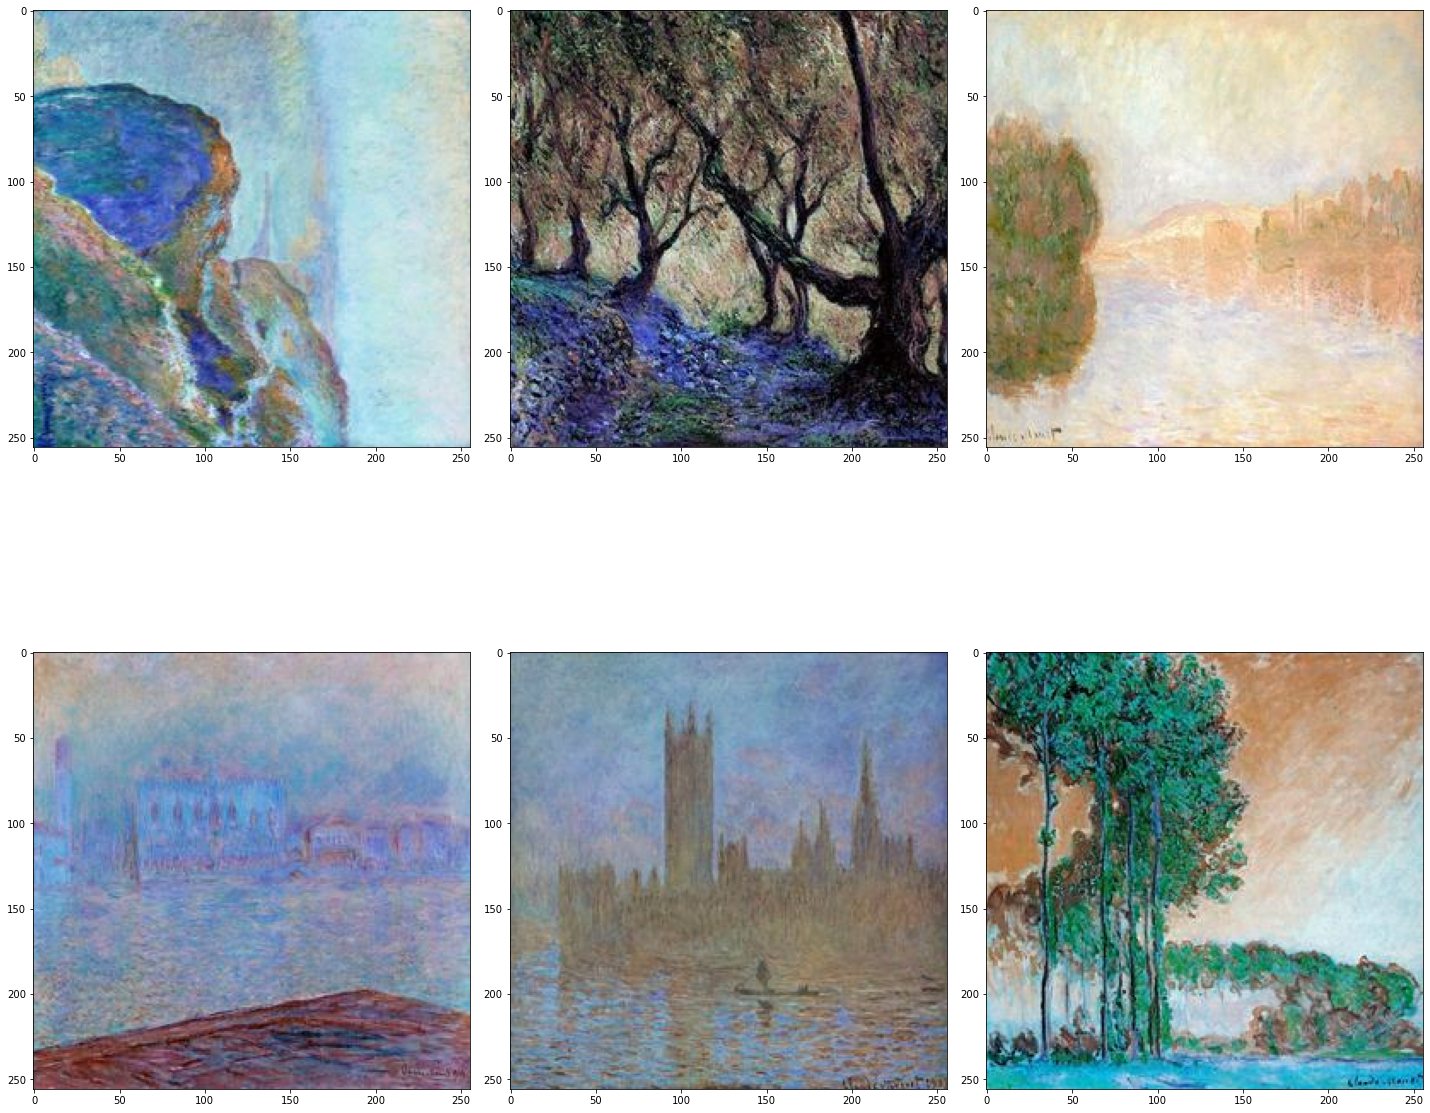

In [18]:
display_sample_images(monet_pics)

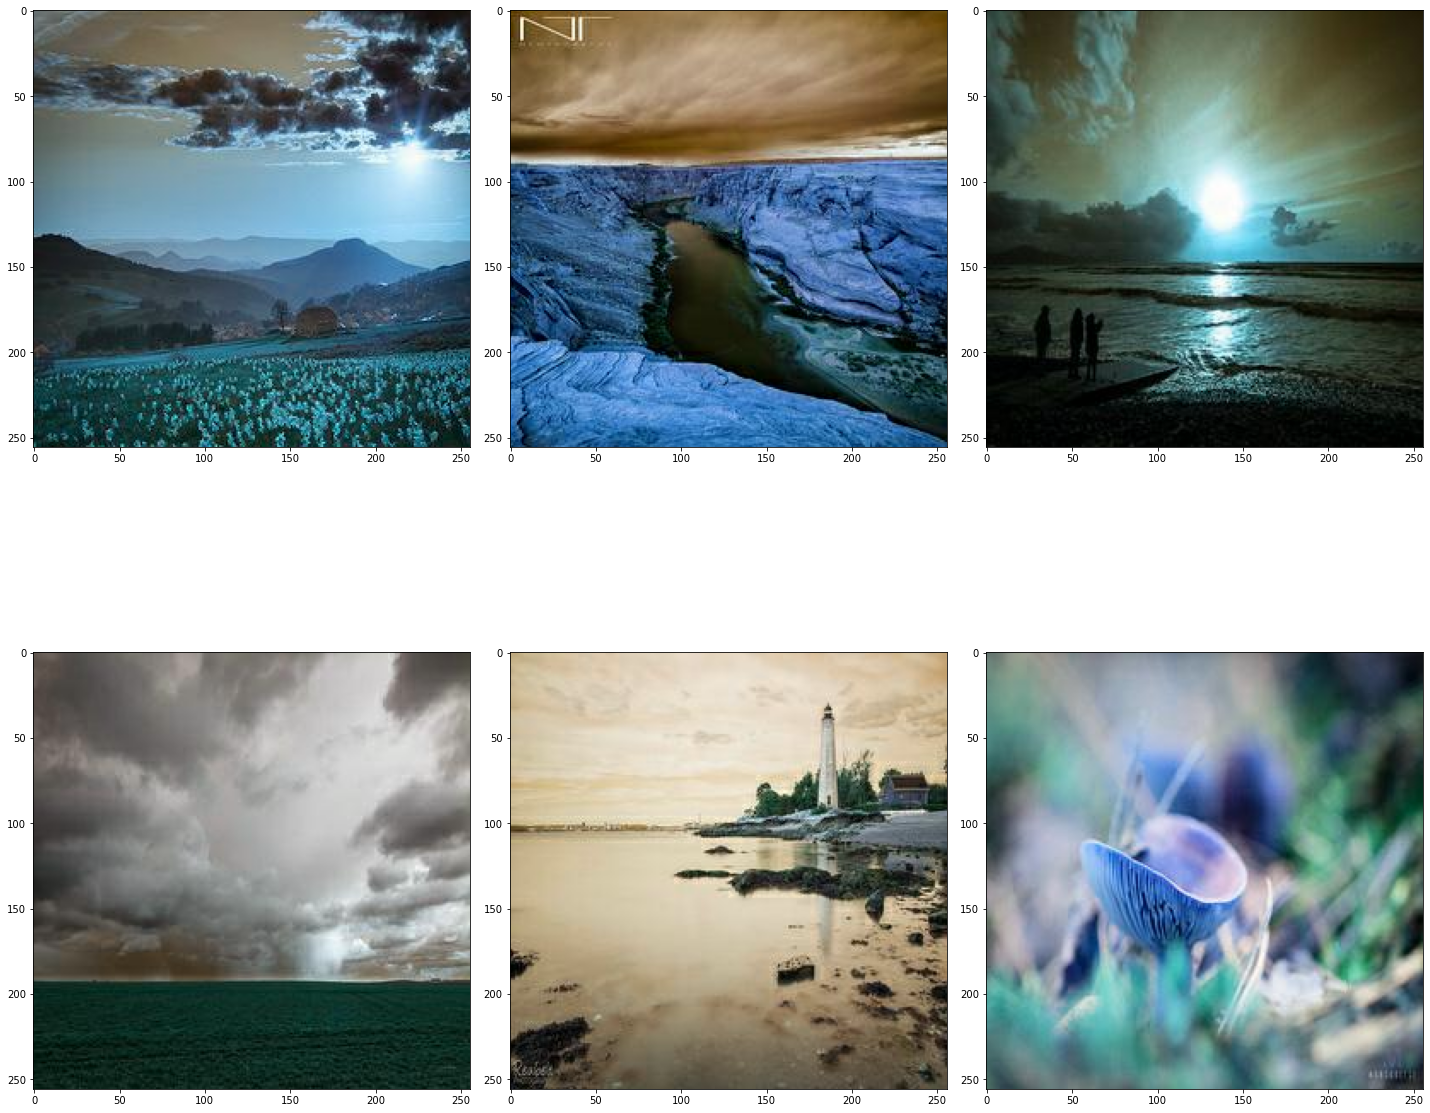

In [19]:
display_sample_images(photo_pics)

We note that the photographs generally have sharp edges, while the Monet paintings appear to have soft edges with many areas showing multiple colors. One way we can try to visualize differences is to look at the distributions of RGB color intensities for the two populations of images.

In [24]:
def rgb_plot(axes,data1,bins,title,ylabel,xlabel):
    axes.hist(data1.flatten(),bins=bins,density = True)
    axes.set_title(title)
    axes.set_ylabel(ylabel,rotation='horizontal',labelpad=35,fontsize=12)
    axes.set_xlabel("Pixel value")
    axes.set_ylim([0.0,0.02])
    return fig.tight_layout()

In [25]:
## convert the outer lists of images into ndarrays
monet = np.array(monet_pics)
print(monet.shape)
photo = np.array(photo_pics)
print(photo.shape)

(300, 256, 256, 3)
(7038, 256, 256, 3)


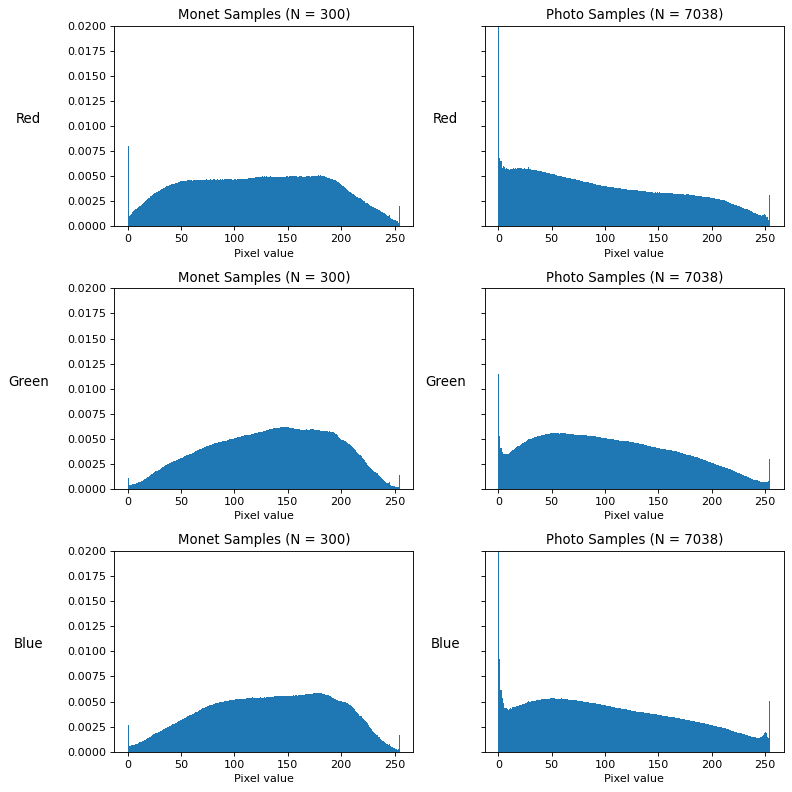

In [26]:
bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(3,2,sharey=True,figsize=(10,10),dpi=80)

rgb_plot(axs[0,0],monet[:,:,:,0],bins,
         'Monet Samples (N = {})'.format(str(monet.shape[0])),'Red','Pixel value')

rgb_plot(axs[0,1],photo[:,:,:,0],bins,
         'Photo Samples (N = {})'.format(str(photo.shape[0])),'Red','Pixel value')

rgb_plot(axs[1,0],monet[:,:,:,1],bins,
         'Monet Samples (N = {})'.format(str(monet.shape[0])),'Green','Pixel value')

rgb_plot(axs[1,1],photo[:,:,:,1],bins,
         'Photo Samples (N = {})'.format(str(photo.shape[0])),'Green','Pixel value')
                       
rgb_plot(axs[2,0],monet[:,:,:,2],bins,
         'Monet Samples (N = {})'.format(str(monet.shape[0])),'Blue','Pixel value')

rgb_plot(axs[2,1],photo[:,:,:,2],bins,
         'Photo Samples (N = {})'.format(str(photo.shape[0])),'Blue','Pixel value')


It appears that for each of the R,G, and B colors the distribution is shifted more to the right (more intense color values) in the Monet paintings versus our sample of photographs.

## Data Preparation

The images are read from the TFRecord format into arrays of 256 pixels by 256 pixels by 3 color channels where each pixel value is an integer in the range o to 255. To prepare the images for use in training the pixels need to be mapped to floats in the range -1.0 to 1.0.  This is accomplished by using the decode_image function shown below:

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image